In [123]:
import torch
smooth_factor = 0.1
def prob_smooth_label(one_hot):
    one_hot = one_hot.float()
    delta = torch.rand([]) * smooth_factor
    num_classes = len(one_hot)
    noise = torch.rand(num_classes)
    noise = noise / noise.sum() * delta
    one_hot = one_hot * (1 - delta) + noise
    return one_hot
oh = torch.rand(3)
prob_smooth_label(torch.tensor([0,0,1,0]))

tensor([0.0333, 0.0223, 0.9112, 0.0332])

In [120]:
torch.rand([])

tensor(0.9816)

In [77]:
from collections import defaultdict
a = defaultdict(lambda:{'labeled':[], 'unlabel':[]})
ls = [a[i] for i in range(5)]

In [80]:
a.items()

dict_items([(0, {'labeled': [], 'unlabel': []}), (1, {'labeled': [], 'unlabel': []}), (2, {'labeled': [], 'unlabel': []}), (3, {'labeled': [], 'unlabel': []}), (4, {'labeled': [], 'unlabel': []})])

In [85]:
import torch
from typing import Iterator, Sequence, Tuple
import numpy as np

import torch
from torch.utils.data.sampler import Sampler
class EndlessGeneratePermutedIndices:
    def __init__(self, length: int) -> None:
        self.length = length
        self.finished = False
        self._sample_perm()

    def _sample_perm(self) -> None:
        self.perm_list = torch.randperm(self.length).tolist()

    def __iter__(self):
        self.finished = False
        self._sample_perm()
        # return self

    def __next__(self) -> int:
        if len(self.perm_list) == 0:
            self._sample_perm()
            self.finished = True
        return self.perm_list.pop()

In [97]:
e = EndlessGeneratePermutedIndices(5)

In [103]:
next(e), e.finished

(3, True)

In [3]:
class WeightedDatasetRandomSampler(Sampler[int]):
    r"""Samples datasets from ``[0,..,len(weights)-1]`` with given probabilities (weights),
    and provide a random index for the chosen dataset.
    Args:
        dataset_weights (sequence)   : a sequence of weights, necessary summing up to one
        dataset_sizes (sequence): size of each dataset
    Example:
        >>> WeightedDatasetRandomSampler([0.2, 0.8], [1, 7])
        [(1, 6),(1, 2),(1, 0),(0, 0),(1, 5),(1, 3),(1, 1),(0, 0),(1, 4)]
    """

    def __init__(self, dataset_weights: Sequence[float], dataset_sizes: Sequence[int]) -> None:
        try:
            np.random.choice(len(dataset_sizes), p=dataset_weights)
        except ValueError as e:
            raise e
        self.dataset_weights = dataset_weights
        self.dataset_sizes = dataset_sizes
        self.sum_cum = np.cumsum([0] + self.dataset_sizes)
        self.num_datasets = len(dataset_sizes)

    def __iter__(self) -> Iterator[int]:
        self.perm_lists = [EndlessGeneratePermutedIndices(ds_size) for ds_size in self.dataset_sizes]
        return self

    def __next__(self) -> int:
        if all([perm_list.finished for perm_list in self.perm_lists]):
            raise StopIteration
        dataset_idx = np.random.choice(self.num_datasets, p=self.dataset_weights)
        return self.sum_cum[dataset_idx] + next(self.perm_lists[dataset_idx])

    def __len__(self) -> int:
        return int(max([ds_size / ds_weight for ds_size, ds_weight in zip(self.dataset_sizes, self.dataset_weights)]))


In [81]:
a = WeightedDatasetRandomSampler([0.2, 0.8], [5, 7])
len(a)

25

8

In [84]:
next(iter(a))

8

In [6]:
np.random.choice(2, p=[0.2,0.8])

1

In [7]:
np.cumsum([0] + [3,7])

array([ 0,  3, 10])

In [12]:
a = [EndlessGeneratePermutedIndices(ds_size) for ds_size in [4,3,6,7]]

In [51]:
next(a[4])

IndexError: list index out of range

In [2]:
import numpy as np
np.clip(10, 1,8)

8

In [1]:
import torch
import numpy as np
import math
import cv2
import random
from PIL import Image

class image():
    def __init__(self) -> None:
        self.img_w, self.img_h = 512, 32
        self.multiscales = True
    def resize_multiscales(self, img, borderType=cv2.BORDER_CONSTANT):
        def _resize_ratio(img, ratio, fix_h=True):
            if ratio * self.img_w < self.img_h:
                if fix_h: # Keep original h and w
                    trg_h = self.img_h 
                else: # Smaller h and original w
                    trg_h = int(ratio * self.img_w)
                trg_w = self.img_w
            else: # Original h and w
                trg_h, trg_w = self.img_h, int(self.img_h / ratio)
            img = cv2.resize(img, (trg_w, trg_h))
            pad_h, pad_w = (self.img_h - trg_h) / 2, (self.img_w - trg_w) / 2
            top, bottom = math.ceil(pad_h), math.floor(pad_h)
            left, right = math.ceil(pad_w), math.floor(pad_w)
            img = cv2.copyMakeBorder(img, top, bottom, left, right, borderType)
            return img

        if True:#self.is_training:
            if True:#random.random() < 0.5:
                # Stupid logic here keep h the same
                base, maxh, maxw = self.img_h, self.img_h, self.img_w
                h, w = random.randint(base, maxh), 600#random.randint(base, maxw)
                return _resize_ratio(img, h / w, fix_h=False)
        return _resize_ratio(img, img.shape[0] / img.shape[1])  # keep aspect ratio
    def standardize_width(self, img, h, min_w, max_w):
        ih, iw, _ = img.shape
        round_to = 8
        new_w = math.ceil(h * iw/ih / round_to) * round_to
        new_w = np.clip(new_w, min_w, max_w)
        return cv2.resize(img, (new_w, h), interpolation = cv2.INTER_AREA)
    def resize(self, img):
        if self.multiscales:
            return self.resize_multiscales(img, cv2.BORDER_REPLICATE)
        else:
            return cv2.resize(img, (self.img_w, self.img_h))

# img = image()
# i = torch.rand(3,32,512)
# img.resize(i)

In [2]:
# def resize(w, h, expected_height, image_min_width, image_max_width):
#     new_w = int(expected_height * float(w) / float(h))
#     round_to = 8
#     new_w = math.ceil(new_w/round_to)*round_to
#     new_w = max(new_w, image_min_width)
#     new_w = min(new_w, image_max_width)

#     return new_w, expected_height
def resize(img, h, min_w, max_w):
    ih, iw, _ = img.shape
    round_to = 8
    new_w = math.ceil(h * iw/ih / round_to) * round_to
    new_w = np.clip(new_w, min_w, max_w)
    return cv2.resize(img, (new_w, h), interpolation = cv2.INTER_AREA)

opencv_image = cv2.imread('0001_tests.png')
print(opencv_image.shape)
opencv_image = resize(opencv_image, 32, 32,512)
def cv2pil(cvi):
    color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
  
    # Displaying the Scanned Image by using cv2.imshow() method
    # cv2.imshow("OpenCV Image", opencv_image)
    
    # Displaying the converted image
    pil_image = Image.fromarray(color_coverted)
    return pil_image, color_coverted
pil_image, color_coverted = cv2pil(opencv_image)
color_coverted.shape

(96, 1841, 3)


(32, 512, 3)

In [5]:
i = image()
i2 = i.resize(opencv_image)
pil, cc = cv2pil(i2)
np.sum(color_coverted-cc)

0

In [6]:
random.randint(7,4)

ValueError: empty range for randrange() (7, 5, -2)

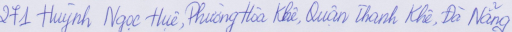

In [4]:
pil